<center style='font-size:28px;'><u><b>Business Analytics</b></u></center>

1. [Project Description](#start)
    * [Data Description](#dd)
2. [Pre-Processing](#pp)
    * [Reading Files](#refa)
    * [`visits`](#vis)
    * [`orders`](#ord)
    * [`costs`](#cos)
    * [Pre-Processing Summation](#ppsum)
3. [Product](#prod)
    * [How many people use it every day, week, and month?](#hmpuei)
    * [How many sessions are there per day?](#hmsa)
    * [What's the length of each session?](#wtloes)
    * [How often do users come back?](#hoducb)
4. [Sales](#sal)
    * [When do people start buying?](#wdpsb)
    * [How many orders do they make during a given period of time?](#hmodtmd)
    * [What is the average purchase size?](#witaps)
    * [How much money do they bring? (LTV)](#hmmdtb)
5. [Marketing](#mrkt)
    * [How much money was spent (overall/per source/over time)?](#hmmwsopo)
    * [How much did customer acquisition from each of the sources cost?](#hmdcafeot)
    * [CAC per Source](#cacps)
    * [How worthwhile where the investments? (ROI)](#roi)
6. [Conclusion](#conc)

# Project Description <a id="start"></a>

Optimizing marketing expenses for Yandex.Afisha

**In particular, study:**

- General usage; visits, orders and relevant metrics - retention, conversion, CAC, LTV and ROI
- Marketing analysis. There are a few marketing sources, and the aim is to see if something useful can be concluded about them   using the data. Relevant metrics per source will be displayed.

## Data Description <a id="dd"></a>

**`visits` (server logs with data on website visits):**

`Uid` - user's unique identifier

`Device` - user's device

`Start Ts` - session start date and time

`End Ts` - session end date and time

`Source Id` - identifier of the ad source the user came from

*All dates in this table are in YYYY-MM-DD format.*

**`orders` (data on orders):**

`Uid` - unique identifier of the user making an order

`Buy Ts` - order date and time

`Revenue` - Yandex.Afisha's revenue from the order

**`costs` (data on marketing expenses):**

`source_id` - ad source identifier

`dt` - date

`costs` - expenses on this ad source on this day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing <a id="pp"></a>

## Reading Files <a id="refa"></a>

In [2]:
try:
    visits = pd.read_csv('visits_log_us.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv')
try:
    orders = pd.read_csv('orders_log_us.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv')
try:
    costs = pd.read_csv('costs_us.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv')

## `visits` <a id="vis"></a>

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


No missing values. That's great!! Though some casting to be done

In [5]:
visits = visits.astype({'Device': 'str', 'Start Ts': 'datetime64[ns]', 'End Ts': 'datetime64[ns]'})
visits = visits[['Device', 'Start Ts', 'End Ts', 'Source Id', 'Uid']]
visits.columns = ['device','start','end','source','uid']

Enriching the table in preperation for cohort analysis and session-duration check:

In [6]:
visits['day']  = visits['start'].astype('datetime64[D]')
visits['week']  = visits['start'].astype('datetime64[W]')
visits['month'] = visits['start'].astype('datetime64[M]')
visits['duration'] = ((visits['end'] - visits['start']).dt.seconds / 60).astype('int')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   device    359400 non-null  object        
 1   start     359400 non-null  datetime64[ns]
 2   end       359400 non-null  datetime64[ns]
 3   source    359400 non-null  int64         
 4   uid       359400 non-null  uint64        
 5   day       359400 non-null  datetime64[ns]
 6   week      359400 non-null  datetime64[ns]
 7   month     359400 non-null  datetime64[ns]
 8   duration  359400 non-null  int32         
dtypes: datetime64[ns](5), int32(1), int64(1), object(1), uint64(1)
memory usage: 23.3+ MB


## `orders` <a id="ord"></a>

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


No missing values. That's great!! Though there's some casting to do

In [9]:
orders['Buy Ts'] = orders['Buy Ts'].astype('datetime64[ns]')
orders = orders[['Uid','Buy Ts', 'Revenue']]
orders.columns = ['uid','buy_ts','price']
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   uid     50415 non-null  uint64        
 1   buy_ts  50415 non-null  datetime64[ns]
 2   price   50415 non-null  float64       
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Enriching the table:

In [10]:
orders['week'] = orders['buy_ts'].astype('datetime64[W]')
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

## `costs` <a id="cos"></a>

In [11]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


No missing values

In [13]:
costs['dt'] = costs['dt'].astype('datetime64[ns]')

Enriching

In [14]:
costs['week']  = costs['dt'].astype('datetime64[W]')
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.columns = ['source','dt','costs','week','month']
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  2542 non-null   int64         
 1   dt      2542 non-null   datetime64[ns]
 2   costs   2542 non-null   float64       
 3   week    2542 non-null   datetime64[ns]
 4   month   2542 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 99.4 KB


## Pre-Processing Summation <a id="ppsum"></a>

- Tables were checked for missing values
- Tables enriched with month and week columns, as well as visit duration in `visits`

# Product <a id="prod"></a>

## How many people use it every day, week, and month? <a id="hmpuei"></a>

In [15]:
dau = visits.groupby(visits['day'])['uid'].nunique().reset_index()
wau = visits.groupby(visits['week'])['uid'].nunique().reset_index()
mau = visits.groupby(visits['month'])['uid'].nunique().reset_index()

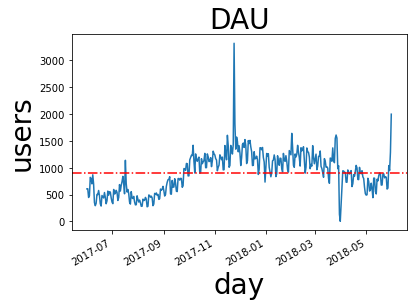

In [16]:
ax = dau.plot('day','uid',legend=False)
plt.title('DAU',fontsize=28)
plt.xlabel('day',fontsize=28)
plt.ylabel('users',fontsize=28)
ax = ax.axhline(y=dau['uid'].mean(), color='r', linestyle='-.')

There's a serious peak around christmas. Besides that, the winter months bring more distinct users - people are more confined home when its cold, so naturally they buy more online. Around June 2018 there's another serious peak, and at April its the lowest point in the year checked with a day with almost no users logged in. For now its unclear why.

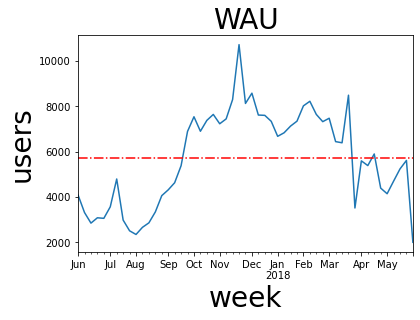

In [17]:
ax = wau.plot('week','uid',legend=False)
plt.title('WAU',fontsize=28)
plt.xlabel('week',fontsize=28)
plt.ylabel('users',fontsize=28)
ax = ax.axhline(y=wau['uid'].mean(), color='r', linestyle='-.')

First, its worth notice the average WAU is lower than the average DAU / 7 - That's because its distinct users, so when the same user logs in every day it contributes 1 for each day's DAU, but only 1 for that week's WAU. So its to be expected that WAU < (DAU / 7).

Now, regarding the unclear fluctations around April and June:

April - There's indeed a steep fall in logging users around April - Again, probably because of the "nicer" weather. But, it looks less dramatic than before - there was a day with 0 DAU, but it didn't affect the WAU significantly, as the WAU's kind of stable around that time. The DAU for April 2018 is around 800, so a WAU of between 4000 to 5600 is totally fine and not sounds dramatic.

As for June 2018 - the DAU experienced a serious peak of 2000, while the WAU is also 2000, but a minimal extremum at this case. So, it seems even though there were a few days with a high DAU, it was mostly the same users, so uniquely for that year WAU=~DAU. Its pretty strange that suddenly, some phenomena made a lot of users, and only them, to log in each day. It's more probable that indeed something made a lot of users to log in, might be the summer vacation anticipation, and together with the end of the survey it made the WAU really low (i.e on that week WAU accounted for less than 7 days so it was lower). And indeed, turns out the last week of the survey accounted for only 1 day, the 31 of May 2018.

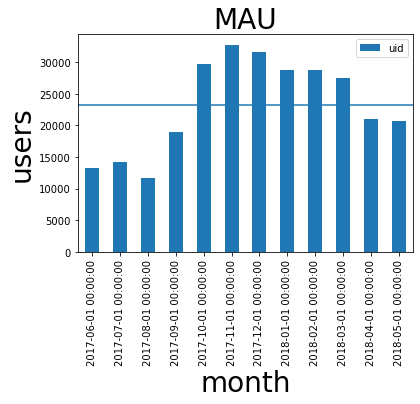

In [18]:
ax = mau.plot.bar(x='month', y='uid')
plt.title('MAU',fontsize=28)
plt.xlabel('month',fontsize=28)
plt.ylabel('users',fontsize=28)
ax = ax.axhline(mau["uid"].mean())

The MAU verifies that winter brings more users, and in it, the christmas time is especially popular time for online shopping

## How many sessions are there per day? <a id="hmsa"></a>

In [19]:
spd = visits.groupby(visits['day'])['uid'].count().reset_index()
spd

,day,uid
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893
...,...,...
359,2018-05-27,672
360,2018-05-28,1156
361,2018-05-29,1035
362,2018-05-30,1410


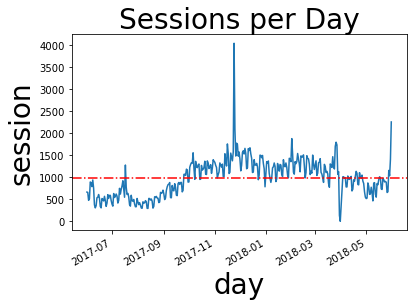

In [20]:
ax = spd.plot('day','uid',legend=False)
plt.title('Sessions per Day',fontsize=28)
plt.xlabel('day',fontsize=28)
plt.ylabel('session',fontsize=28)
ax = ax.axhline(y=spd['uid'].mean(), color='r', linestyle='-.')

The general behavior is the same as DAU - Winter admits more sessions, local peaks at August, October and April, and a serious peak at christmas. The average is 1000, the DAU's average is around 950. So, about one out of 19 users is likely to comeback for another session every day.

In [21]:
(spd['uid'] / dau['uid']).to_frame().describe()

,uid
count,364.000000
mean,1.082170
std,0.020876
min,1.000000
25%,1.070321
50%,1.082488
75%,1.093876
max,1.217837


Mean and median are around the same, so the distribution is around normal. Around 8% of users come back for another session every day, as opposed to earlier 1/19 = 5%.

## What's the length of each session? <a id="wtloes"></a>

In [22]:
visits['duration'].mean() # in minutes

10.724343350027825

Looks like the average customer doesn't need a lot of time on the company's website. Good chance that average customer already knows what he's looking for.

## How often do users come back? <a id="hoducb"></a>

Retention is the sought after metric here

In [23]:
first_visit = visits.groupby(['uid'])['start'].min().reset_index()
first_visit.columns = ['uid', 'first_session']

In [24]:
visits = visits.merge(first_visit, how='inner',on=['uid'])

In [25]:
visits['cohort'] = visits['first_session'].astype('datetime64[M]')
visits['session_month'] = visits['start'].astype('datetime64[M]')
visits['age'] = ((visits.session_month - visits.cohort) / np.timedelta64(1, 'M')).round().astype('int')

In [26]:
cohorts = visits.pivot_table(index='cohort',
                  columns='age',
                  values='uid',
                  aggfunc='nunique').fillna(0)

In [27]:
retention = cohorts.iloc[:,0:].div(cohorts[0], axis=0)

Finally, a heatmap is best in visualising and looking at different cohorts

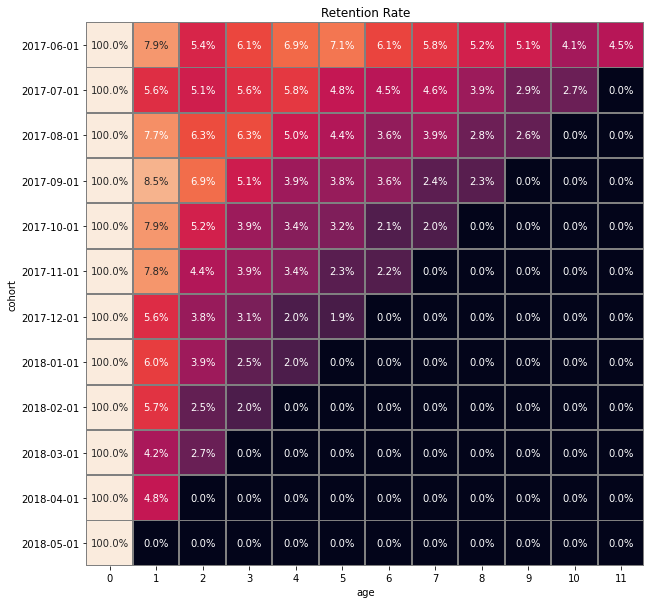

In [28]:
retention.index = retention.index.astype(str)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey',  vmax=0.1, cbar_kws= {'orientation': 'horizontal'},cbar=False,ax=ax 
            ).set(title = 'Retention Rate')
plt.show()

Generaly, users are less likely to come back as their cohort age is older. With a few small deviations.
The cohorts of the time before christmas are better, and in it, June is the best, with August and September behind at 2nd place. Maybe the anticipation and knowledge of christmas somewhere in the future make those cohorts come back more.

# Sales <a id="sal"></a>

## When do people start buying? <a id="wdpsb"></a>

Conversion's the key metric here

In [29]:
first_visit

,uid,first_session
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228164,18446403737806311543,2017-11-30 03:36:00
228165,18446424184725333426,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00
228167,18446621818809592527,2017-12-27 13:27:00


In [30]:
first_order = orders.groupby(['uid'])['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'first_order']

In [31]:
conv = first_visit.merge(first_order, how='right',on=['uid'])
conv

,uid,first_session,first_order
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00


In [32]:
conv['conversion'] = ((pd.to_datetime(conv['first_order'])-pd.to_datetime(conv['first_session']))/np.timedelta64(1,'D')).astype('int')

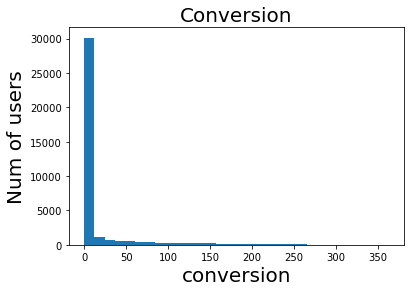

In [33]:
conv['conversion'].plot.hist(bins=30)
plt.title('Conversion', fontsize=20)
plt.xlabel('conversion', fontsize=20)
plt.ylabel('Num of users', fontsize=20)
plt.show()

So, as expected, most users converse following their first visit. Though its not clear whats the conversion distribution in first few days after first visit. So, here's a plot starting from day after first visit:

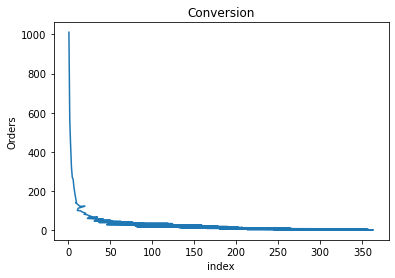

In [34]:
ax = conv['conversion'].value_counts().reset_index().drop(0,axis=0).plot('index','conversion',legend=False)
ax.set_title('Conversion')
ax.set_ylabel('Orders')
plt.show()

Its all about the first 25 days tops.

In [35]:
conv.conversion.median()

0.0

In [36]:
conv.conversion.mean()

16.7298688497659

As expected, with so many users buying at their first day (26000 out of 36000), the median age for placing the first order is 0 days. However, there are users who place their first order after almost a year. The mean is 16, so apparently those users are not a minority.

In [37]:
print('The overall conversion is {:.1%}'.format(orders['uid'].nunique()/visits['uid'].nunique()))

The overall conversion is 16.0%


## How many orders do they make during a given period of time? <a id="hmodtmd"></a>

In [38]:
orders = orders.merge(first_order,how='left',on='uid')
orders['first_order_month']=orders['first_order'].astype('datetime64[M]')

In [39]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','cohort_size']
cohort_sizes.head()

,first_order_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [40]:
cohort = orders.groupby(['first_order_month','month'])['price'].count().reset_index()
cohort.columns = ['first_order_month','month','orders']
cohort

,first_order_month,month,orders
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292
...,...,...,...
74,2018-03-01,2018-05-01,176
75,2018-04-01,2018-04-01,2495
76,2018-04-01,2018-05-01,195
77,2018-05-01,2018-05-01,3249


And indeed,  1+2+3+...+10+11+12=78, and another row for the single day in June 2018.

In [41]:
cohort = cohort.merge(cohort_sizes,on=['first_order_month'])
cohort['age_month'] = ((cohort['month'] - cohort['first_order_month']) / np.timedelta64(1,'M')).round()
cohort['orders_per_buyer'] = cohort['orders'] / cohort['cohort_size']
cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_order_month  79 non-null     datetime64[ns]
 1   month              79 non-null     datetime64[ns]
 2   orders             79 non-null     int64         
 3   cohort_size        79 non-null     int64         
 4   age_month          79 non-null     float64       
 5   orders_per_buyer   79 non-null     float64       
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 4.3 KB


In [42]:
cohort_piv = cohort.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum'
)

cohort_piv.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.1,0.08,0.05,0.04
2017-07-01,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,
2017-08-01,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,,
2017-09-01,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,,,
2017-10-01,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,,,,
2017-11-01,1.18,0.1,0.04,0.05,0.03,0.01,0.02,,,,,
2017-12-01,1.15,0.06,0.05,0.04,0.02,0.02,,,,,,
2018-01-01,1.12,0.07,0.05,0.02,0.02,,,,,,,
2018-02-01,1.12,0.06,0.02,0.02,,,,,,,,


Following registration, the average user place around 1.15 orders. In the months after, the average user place around 0.05, i.e after the first month, only 1 out of 20 users place a order each month. The first cohort has better stats, about twice as much. Its not clear for now why this cohort is so good.

In [43]:
cohort_piv = cohort.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)
cohort_piv.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


Here its much more visible how the first cohort is "better" - after a year, the average user placed more than 2 orders! The rest have lower numbers, even when taking into account their age is younger

## What is the average purchase size? <a id="witaps"></a>

In [44]:
# find out how much each user spends

avg_check = orders.groupby(['uid'])['price'].sum().reset_index()
avg_check['price'].quantile(.99)

44.233999999999654

So, most users spend 45$ at most, overall

In [45]:
avg_check['price'].describe()

count    36523.000000
mean         6.901328
std         88.128535
min          0.000000
25%          1.470000
50%          3.050000
75%          5.800000
max      11810.180000
Name: price, dtype: float64

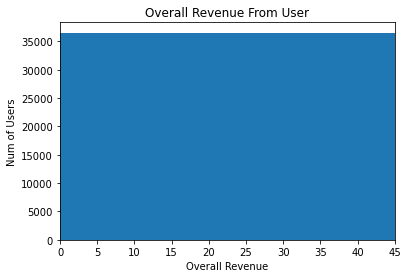

In [46]:
ax = avg_check.price.plot.hist(bins=7,xlim=(0,45))
ax.set_title('Overall Revenue From User')
ax.set_ylabel('Num of Users')
ax.set_xlabel('Overall Revenue')
plt.show()

That's not too informative. Seems like most orders cost about the same.

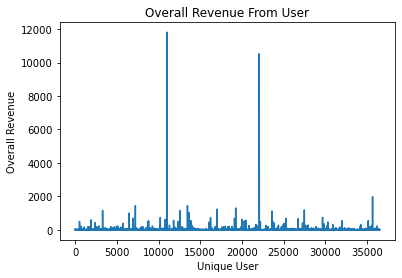

In [47]:
ax = avg_check.price.plot()
ax.set_title('Overall Revenue From User')
ax.set_ylabel('Overall Revenue')
ax.set_xlabel('Unique User')
plt.show()

There are about 3 users that exceed 2000 dollars, around 15 spending over 1000$ and the absolute majority well lower.

In [48]:
avg_cohort = orders.groupby(['first_order_month','month'])['price'].mean().reset_index()
avg_cohort['age_month'] = ((avg_cohort['month'] - avg_cohort['first_order_month']) / np.timedelta64(1,'M')).round()
avg_cohort.head()

,first_order_month,month,price,age_month
0,2017-06-01,2017-06-01,4.060106,0.0
1,2017-06-01,2017-07-01,5.547006,1.0
2,2017-06-01,2017-08-01,5.088161,2.0
3,2017-06-01,2017-09-01,8.545575,3.0
4,2017-06-01,2017-10-01,7.084178,4.0


In [49]:
avg_cohort_piv = avg_cohort.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='price', 
    aggfunc='mean'
)

avg_cohort_piv.round(2).fillna(0)

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,0.00
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.70,5.60,0.00,0.00
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,0.00,0.00,0.00
2017-10-01,4.37,7.41,5.13,5.59,5.10,5.07,4.28,4.01,0.00,0.00,0.00,0.00
2017-11-01,4.37,4.10,4.47,6.28,4.44,3.73,4.60,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,3.69,4.44,6.45,7.52,2.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,3.71,4.58,3.45,3.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


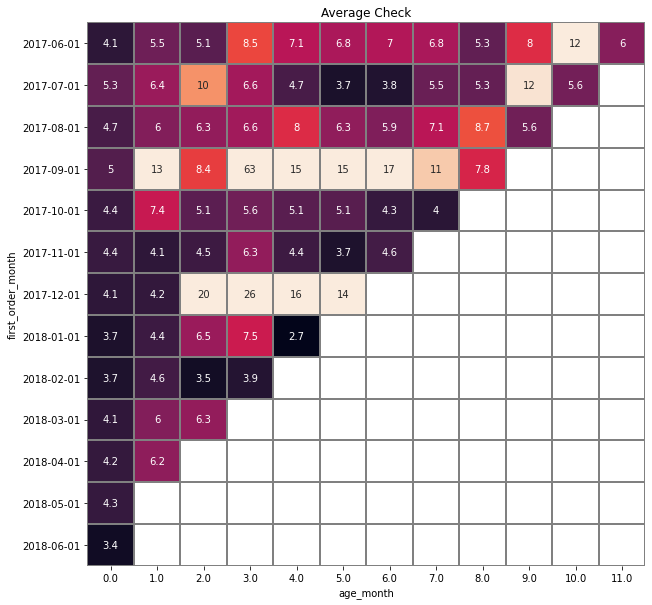

In [50]:
avg_cohort_piv.index = avg_cohort_piv.index.astype(str)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(avg_cohort_piv, annot=True, linewidths=1, linecolor='grey',cbar_kws= {'orientation': 'horizontal'},cbar=False,ax=ax,vmin=3, vmax=12 
            ).set(title = 'Average Check')
plt.show()

In general, average check gets bigger with age. There are some exceptional cohorts, which have some months with very high average check - age 3 and onwards for September cohort, and some months in December cohort. No obvious pattern can explain it for now. Its probably outliers caused by some specifically expensive orders.

In [51]:
orders.price.mean()

4.999646930476993

Average overall order price is 5$.

## How much money do they bring? (LTV) <a id="hmmdtb"></a>

In [52]:
#get the revenue per cohort in each month

#adding margin_rate for compatability
MARGIN_RATE = 1

ltv_cohort = orders.groupby(['first_order_month','month'])['price'].sum().reset_index()
ltv_cohort.columns = ['first_order_month','month','price']
#merge with the cohort size
ltv_cohort = ltv_cohort.merge(cohort_sizes,on=['first_order_month'])
ltv_cohort['age'] = ((ltv_cohort['month'] - ltv_cohort['first_order_month']) / np.timedelta64(1,'M')).round()
ltv_cohort['ltv'] = (ltv_cohort['price'] * MARGIN_RATE)/ltv_cohort['cohort_size']
ltv_cohort

,first_order_month,month,price,cohort_size,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2.0,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,0.0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,1.0,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,0.0,4.660562


In [53]:
ltv_cohort_piv = ltv_cohort.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)

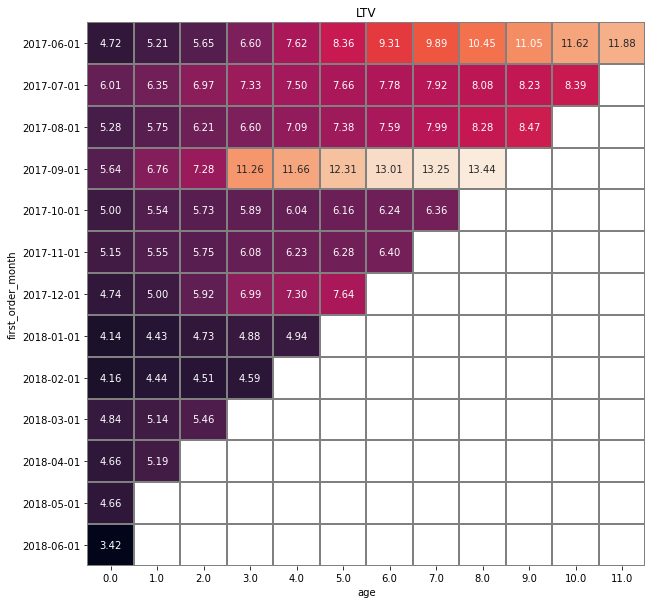

In [54]:
ltv_cohort_piv.index = ltv_cohort_piv.index.astype(str)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ltv_cohort_piv, annot=True, fmt='.2f', linewidths=1, linecolor='grey',cbar=False, cbar_kws= {'orientation': 'horizontal'} 
            ).set(title ='LTV')
plt.show()

Earlier, it came clear that September and December cohorts experienced some very expensive orders. And indeed, There are "jumps" in the LTV for those cohorts, between age 2 to 3. Those jumps make September the best LTV-wise cohort, though its again probably by chance, as that one or few customers could have place their orders at other month and different cohorts at equal probability. June cohort, once again, seem like a very good cohort - something definitely made it so good, as its high LTV doesn't come from specific users but from the average user, i.e outliers didn't had such a big impact on that cohort.

# Marketing <a id="mrkt"></a>

## How much money was spent (overall/per source/over time)? <a id="hmmwsopo"></a>

In [55]:
print('Total marketing cost is {}'.format(costs['costs'].sum()))

Total marketing cost is 329131.62


In [56]:
marketing_per_source = costs.groupby(['source'])['costs'].sum().reset_index()
marketing_per_source.head(10)

,source,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Source 3 is way more expensive than the others. Sources 4,5 and 2 are way back, at about half the cost.

In [57]:
# marketing over time
costs=costs.sort_values(by=['dt','source'])

# dividing sources to make visualisation clearer. when all together they hide each other
costs1 = costs.query('source == 3 or source == 4 or source == 5')
costs2 = costs.query('source == 1 or source == 2 or source == 9 or source == 10')

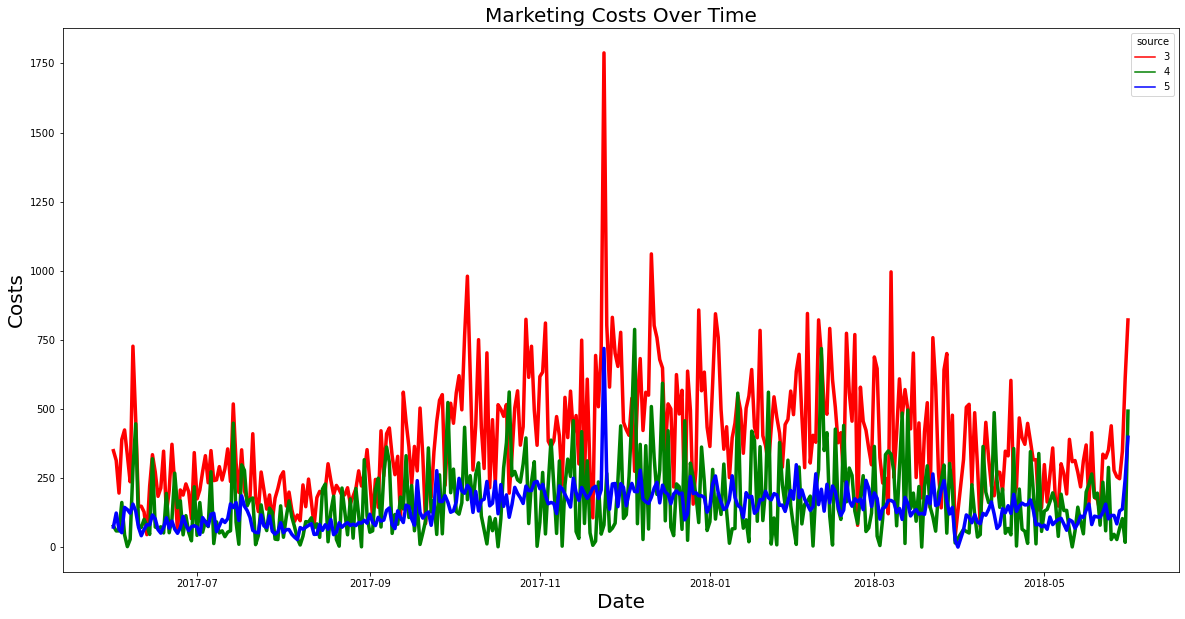

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(data=costs1, x="dt", y="costs", hue="source",palette=['r', 'g','b'],linewidth=3.5)
ax.set_title('Marketing Costs Over Time',fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Costs',fontsize=20)
plt.show()

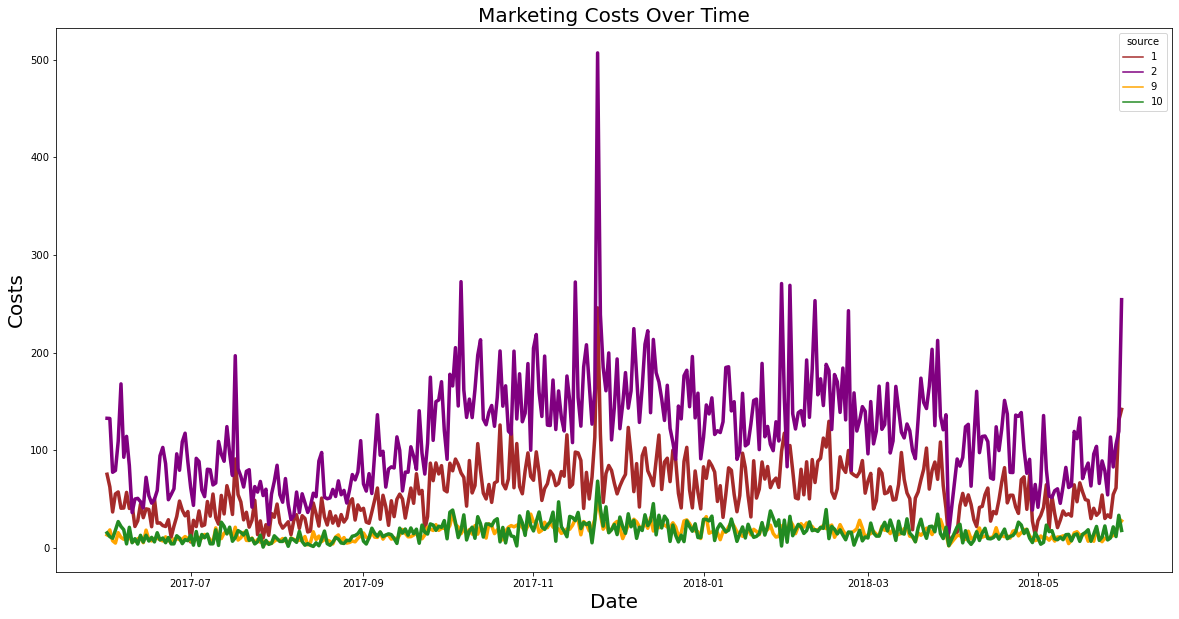

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(data=costs2, x="dt", y="costs", hue="source",palette=['brown', 'purple', 'orange', 'forestgreen'],linewidth=3.5)
ax.set_title('Marketing Costs Over Time',fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Costs',fontsize=20)
plt.show()

Most sources seem to correlate with DAU/MAU - at winter the expenses going up, specifically around christmas. Sources 9 and 10 didn't had too much of expenses, and both don't fluctuate too much during the year - though source 10 has a peak at christmas like the others. 

## How much did customer acquisition from each of the sources cost? <a id="hmdcafeot"></a>

The relevant data will be handled monthly - 

In [60]:
marketing_by_month = costs.groupby(['month'])['costs'].sum().reset_index()
marketing_by_month.head()

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [61]:
buyers_per_month = orders.groupby(['first_order_month'])['uid'].nunique().reset_index()
buyers_per_month.columns = ['month','buyers']
buyers_per_month.head()

,month,buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [62]:
CAC_per_month = marketing_by_month.merge(buyers_per_month,how='left',on=['month'])
CAC_per_month['CAC'] = CAC_per_month['costs']/CAC_per_month['buyers']
CAC_per_month.head()

,month,costs,buyers,CAC
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327


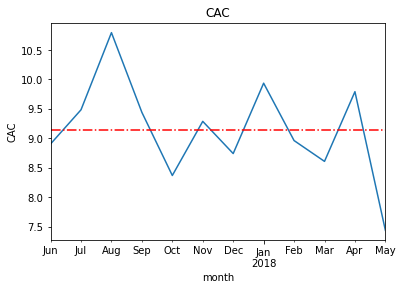

In [63]:
ax = CAC_per_month.plot('month','CAC',title='CAC',legend=False)
ax.set_xlabel('month')
ax.set_ylabel('CAC')
ax = ax.axhline(y=CAC_per_month['CAC'].mean(), color='r', linestyle='-.')

It seems CAC correlate to low sales - and it makes sense, as times of low sales are the time the business builds awareness for itself, as preperation for christmas and such.

## CAC per Source <a id="cacps"></a>

In [64]:
visits.groupby(['uid'])['source'].nunique()[1260655184775459]

2

So, some users have more than one source id. So each user will presume to have come by his first visit source id.

In [65]:
first_source = visits.sort_values('start').groupby('uid').first()['source'].reset_index()
first_source.columns = ['uid','first_source']
first_source.head()

,uid,first_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [66]:
orders = orders.merge(first_source,on=['uid'],how='left')
orders.head()

,uid,buy_ts,price,week,month,first_order,first_order_month,first_source
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,1
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,3


In [67]:
marketing_by_month_source = costs.groupby(['month','source'])['costs'].sum().reset_index()
marketing_by_month_source.head()

,month,source,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [68]:
buyers_per_month_source = orders.groupby(['first_order_month','first_source'])['uid'].nunique().reset_index()
buyers_per_month_source.columns = ['month','source','buyers']
buyers_per_month_source.head()

,month,source,buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [69]:
#actual cac calculations
CAC_per_month_source = marketing_by_month_source.merge(buyers_per_month_source,how='left',on=['month','source'])
CAC_per_month_source['CAC'] = CAC_per_month_source['costs']/CAC_per_month_source['buyers']
CAC_per_month_source.head()

,month,source,costs,buyers,CAC
0,2017-06-01,1,1125.61,190,5.924263
1,2017-06-01,2,2427.38,235,10.329277
2,2017-06-01,3,7731.65,638,12.118574
3,2017-06-01,4,3514.80,413,8.510412
4,2017-06-01,5,2616.12,384,6.812813


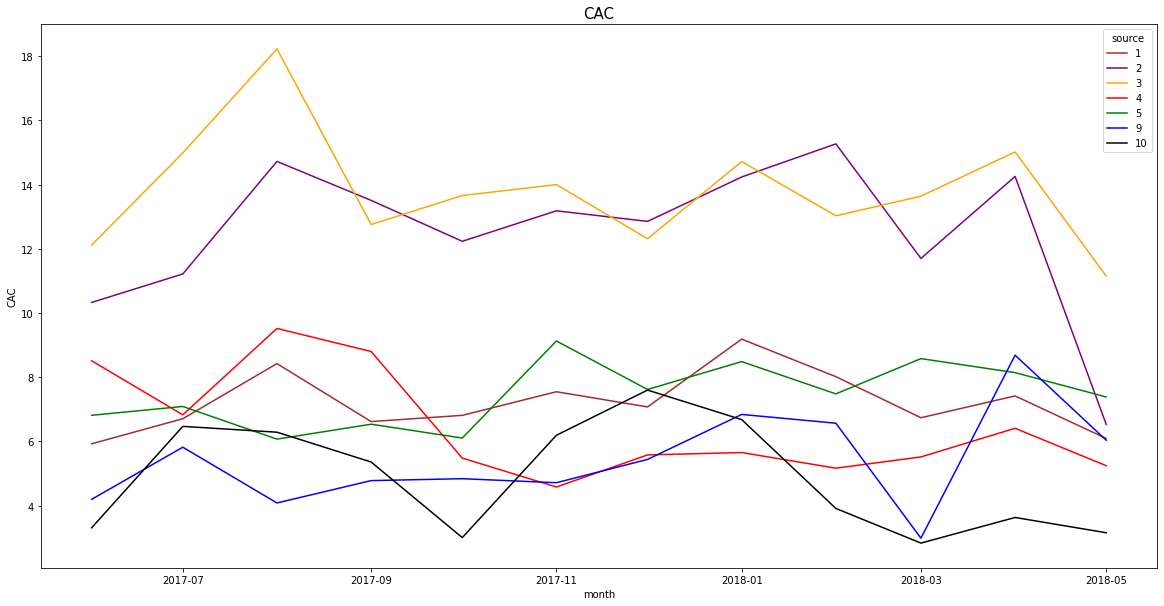

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(data=CAC_per_month_source, x="month", y="CAC", hue="source",palette=['brown', 'purple', 'orange','r','g','b','black'])
ax.set_title('CAC',fontsize=15)
ax.set_xlabel('month')
ax.set_ylabel('CAC')
plt.show()

As before, it seems at times of less DAU the markenting costs rise, seperately and per buyer. Sources 2 and 3 have higher CAC than the rest, by far.

## How worthwhile where the investments? (ROI) <a id="roi"></a>

In [71]:
CAC_per_month_ROI = CAC_per_month[['month','CAC']]
CAC_per_month_ROI.columns = ['first_order_month','CAC']
ROI = ltv_cohort.merge(CAC_per_month_ROI,on=['first_order_month'],how='left')
ROI.head()

,first_order_month,month,price,cohort_size,age,ltv,CAC
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091


In [72]:
ROI['ROI'] = ROI['ltv']/ROI['CAC']
roi_piv = ROI.pivot_table(
    index='first_order_month', columns='age', values='ROI', aggfunc='mean'
).cumsum(axis=1).round(2) 

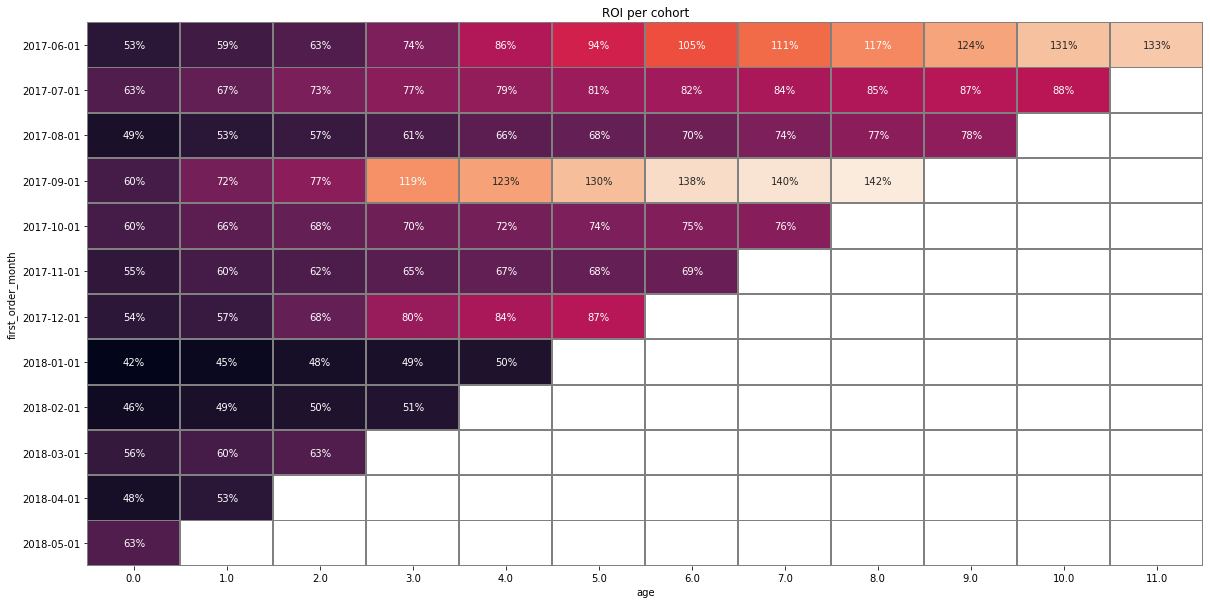

In [73]:
fig, ax = plt.subplots(figsize=(20,10))
roi_piv.index = roi_piv.index.astype(str)
sns.heatmap(roi_piv, annot=True, fmt='.0%', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'},cbar=False, 
            ).set(title ='ROI per cohort')
plt.show()

Again, June cohort shows high numbers, as well as some months of September cohort, which contain some highly expensive orders.

In [74]:
ltv_per_source = orders.groupby(['first_source'])['uid','price'].agg({'uid':'nunique','price':'sum'}).reset_index()
ltv_per_source.columns = ['source','buyers','price']
ltv_per_source['ltv'] = ltv_per_source['price']/ltv_per_source['buyers']
ltv_per_source

<ipython-input-74-f67165e03576>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ltv_per_source = orders.groupby(['first_source'])['uid','price'].agg({'uid':'nunique','price':'sum'}).reset_index()


,source,buyers,price,ltv
0,1,2899,31090.55,10.724577
1,2,3506,46923.61,13.383802
2,3,10473,54511.24,5.204931
3,4,10296,56696.83,5.506685
4,5,6931,52624.02,7.592558
5,7,1,1.22,1.220000
6,9,1088,5759.40,5.293566
7,10,1329,4450.33,3.348631


In [75]:
roi_per_source = marketing_per_source.merge(ltv_per_source,on=['source'])
roi_per_source['cac'] = roi_per_source['costs']/roi_per_source['buyers']
roi_per_source['romi'] = roi_per_source['ltv']/roi_per_source['cac']
roi_per_source

,source,costs,buyers,price,ltv,cac,romi
0,1,20833.27,2899,31090.55,10.724577,7.186364,1.492351
1,2,42806.04,3506,46923.61,13.383802,12.209367,1.096191
2,3,141321.63,10473,54511.24,5.204931,13.493901,0.385725
3,4,61073.60,10296,56696.83,5.506685,5.931779,0.928336
4,5,51757.10,6931,52624.02,7.592558,7.467479,1.016750
5,9,5517.49,1088,5759.40,5.293566,5.071222,1.043844
6,10,5822.49,1329,4450.33,3.348631,4.381106,0.764335


Source 1 seems to be the most trustful. On the other hand, source 3 is really not - however it should be remembered that its the source who brings the most buyers, together with being the one that cost the most for the company.

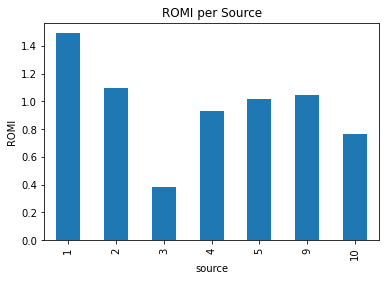

In [76]:
roi_per_source.plot.bar(x='source',y='romi',legend=False)
plt.title('ROMI per Source')
plt.xlabel('source')
plt.ylabel('ROMI')
plt.show()

# Conclusion <a id="conc"></a>

The average customer makes most of his spending in the days following registration. Its important to try and make customers come back - its always going to make the chance of a purchase bigger - but with that said, by this research it seems most energy and fund should be directed to attract customers in the first place.

When analysing by cohorts it became clear that something is very good in June cohort, but unfortunately no hypotheses as to the cause for that.

Marketing - Source 3 need to be thinked over. Its a must, as it brings a lot of buyers; But cost a lot and showcase a low ROMI as well. More trusted and only a bit less popular is source 4, with greater ROI and lower CAC. Source 1 is the best in terms of money payback, and has a high LTV value - so its advisory to invest more in it.